In [90]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='7356',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/SANDY/Desktop/DATA ANALYSIS FILES - JULY 2024\PROJECT 1- USING SQL AND PYTHON'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

<>:26: SyntaxWarning: invalid escape sequence '\P'
<>:26: SyntaxWarning: invalid escape sequence '\P'
C:\Users\SANDY\AppData\Local\Temp\ipykernel_3860\3775692567.py:26: SyntaxWarning: invalid escape sequence '\P'
  folder_path = 'C:/Users/SANDY/Desktop/DATA ANALYSIS FILES - JULY 2024\PROJECT 1- USING SQL AND PYTHON'


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector

db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="7356",
                           database="ecommerce")

cur=db.cursor()

In [5]:
query="""select distinct customer_city
            from customers"""

cur.execute(query)

dataset=cur.fetchall()
#dataset
df=pd.DataFrame(dataset)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [18]:
query="""select count(order_id)
        from orders
        where year(order_purchase_timestamp)=2017"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
"Total order placed in year 2017 are: ",dataset[0][0]

('Total order placed in year 2017 are: ', 135303)

In [6]:
query="""select products.product_category CATEGORY, round(sum(payments.payment_value),2) SALES
from products
join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by CATEGORY"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
df=pd.DataFrame(dataset,columns=["CATEGORY","SALES"])
df.head(5)

,CATEGORY,SALES
0,perfumery,16215637.12
1,Furniture Decoration,45765644.54
2,telephony,15580225.62
3,bed table bath,54801717.47
4,automotive,27273418.60


In [7]:
query="""select upper(products.product_category) CATEGORY, round(sum(payments.payment_value),2) SALES
from products
join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by CATEGORY"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
df=pd.DataFrame(dataset,columns=["CATEGORY","SALES"])
df.head(5)

,CATEGORY,SALES
0,PERFUMERY,16215637.12
1,FURNITURE DECORATION,45765644.54
2,TELEPHONY,15580225.62
3,BED TABLE BATH,54801717.47
4,AUTOMOTIVE,27273418.60


In [30]:
query="""select sum(case
			when payment_installments>0
			then 1
            else 0
            end) / count(*)*100
from ecommerce.payments;"""
cur.execute(query)
dataset=cur.fetchall()
"% of orders that were paid in installments: ", dataset
#df=pd.DataFrame(dataset)
#df

('% of orders that were paid in installments: ', [(Decimal('99.9981'),)])

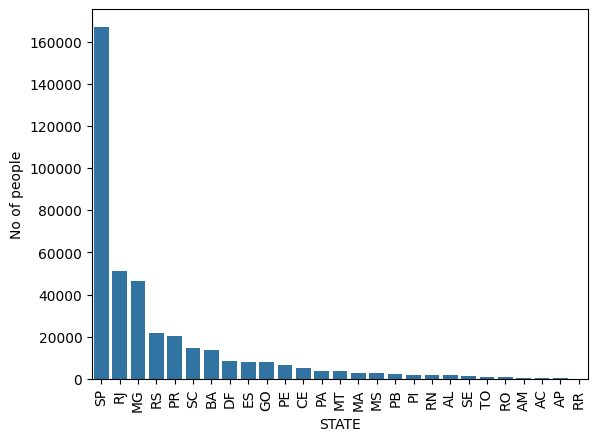

In [8]:
query="""select count(customer_id), customer_state
from ecommerce.customers
group by customer_state"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
df=pd.DataFrame(dataset,columns=["No of people","STATE"])
#df
df=df.sort_values(by="No of people", ascending=False)
df.head(5)
sns.barplot(data=df,x="STATE",y="No of people")
plt.xticks(rotation=90)
plt.show()

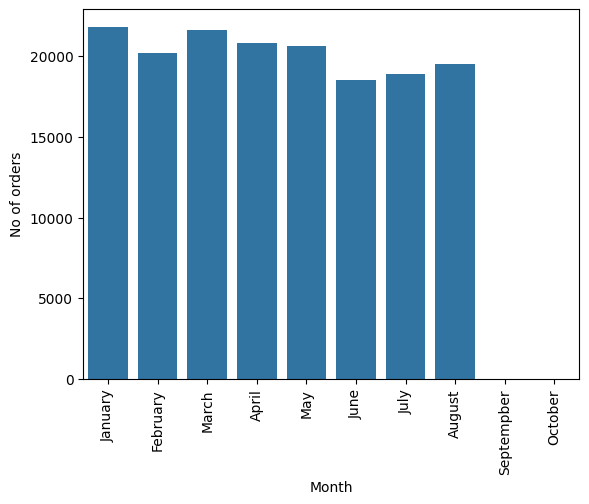

In [68]:
#Calculate the number of orders per month in 2018
query="""select monthname(order_purchase_timestamp), count(order_id)
from ecommerce.orders
where year(order_purchase_timestamp)=2018
group by monthname(order_purchase_timestamp)"""
cur.execute(query)
dataset=cur.fetchall()
"No of order for all months in 2018 are: ",dataset
df=pd.DataFrame(dataset,columns=["Month","No of orders"])
#df
o=["January","February","March","April","May","June","July","August","Septempber","October"]
sns.barplot(data=df, x=df["Month"], y=df["No of orders"], order=o)
plt.xticks(rotation=90)
plt.show()


In [9]:
#Find the average number of products per order, grouped by customer city
query="""with count_per_order as (
select orders.order_id, orders.customer_id, count(order_items.order_item_id) as oc
from ecommerce.orders
join ecommerce.order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select upper(customers.customer_city), round(avg(count_per_order.oc),2)
from ecommerce.customers
join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by avg(count_per_order.oc) desc"""
cur.execute(query)
dataset=cur.fetchall()
#"Avg no of orders city wise are: ",dataset
df=pd.DataFrame(dataset,columns=["CITY","Avg Order"])
df.head(5)

,CITY,Avg Order
0,PADRE CARVALHO,56.00
1,CELSO RAMOS,52.00
2,DATAS,48.00
3,CANDIDO GODOI,48.00
4,MATIAS OLIMPIO,40.00


In [10]:
#Calculate the percentage of total revenue contributed by each product category
query="""select upper(products.product_category) CATEGORY, 
round((sum(payments.payment_value)/(select sum(payments.payment_value) from  ecommerce.payments))*100,2) SALES
from ecommerce.products
join ecommerce.order_items
on products.product_id = order_items.product_id
join ecommerce.payments
on order_items.order_id = payments.order_id
group by CATEGORY
order by SALES desc"""
cur.execute(query)
dataset=cur.fetchall()
#"% of total revenue according to product categories: ",dataset
df=pd.DataFrame(dataset,columns=["Avg Order","CITY"])
df.head(5)

,Avg Order,CITY
0,BED TABLE BATH,85.58
1,HEALTH BEAUTY,82.82
2,COMPUTER ACCESSORIES,79.22
3,FURNITURE DECORATION,71.47
4,WATCHES PRESENT,71.42


In [97]:
#Identify the correlation between product price and the number of times a product has been purchased.
query="""select upper(products.product_category) CATEGORY, 
count(order_items.order_id) ORDERS_PER_CATEGORY,
avg(order_items.price) PRICE_PER_CATEGORY
from ecommerce.products
join ecommerce.order_items
on products.product_id = order_items.product_id
group by CATEGORY
order by PRICE_PER_CATEGORY desc"""
cur.execute(query)
dataset=cur.fetchall()
#"Correlation between product price and the number of times a product has been purchased: ",dataset
df=pd.DataFrame(dataset,columns=["CATEGORY","ORDERS_PER_CATEGORY","PRICE_PER_CATEGORY"])
#df

arr1=df["ORDERS_PER_CATEGORY"]
arr2=df["PRICE_PER_CATEGORY"]
a=np.corrcoef([arr1,arr2])
print(a)
print("The required correlation is: ",a[0][1])

[[ 1.         -0.10631552]
 [-0.10631552  1.        ]]
The required correlation is:  -0.10631552237549526


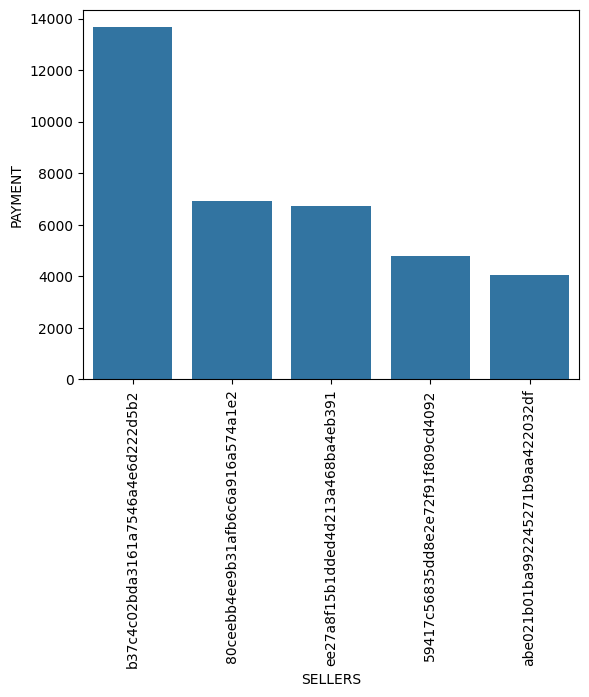

In [106]:
#Calculate the total revenue generated by each seller, and rank them by revenue.
query2="""SET sql_mode=(SELECT REPLACE(@@sql_mode,'ONLY_FULL_GROUP_BY',''))"""
cur.execute(query2)

query="""select *, dense_rank() over (order by PAYMENT desc) RANKS
from
(select order_items.seller_id SELLERS, payments.payment_value PAYMENT
from ecommerce.order_items
join ecommerce.payments
on order_items.order_id = payments.order_id
group by SELLERS) 
as OVERALL_TABLE"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
df=pd.DataFrame(dataset,columns=["SELLERS","PAYMENT","RANKS"])
#df
sns.barplot(data=df.head(5),x="SELLERS",y="PAYMENT")
plt.xticks(rotation=90)
plt.show()

In [109]:
#Calculate the moving average of order values for each customer over their order history.
#query2="""SET sql_mode=(SELECT REPLACE(@@sql_mode,'ONLY_FULL_GROUP_BY',''))"""
#cur.execute(query2)

query="""select CUST_ID, TIMES, PAYMENT,
avg(PAYMENT) over (partition by CUST_ID
order by TIMES rows between 2 preceding and current row) as MA
from
(select orders.customer_id CUST_ID, orders.order_purchase_timestamp TIMES,
payments.payment_value PAYMENT
from ecommerce.orders
join ecommerce.payments
on orders.order_id = payments.order_id) AS A"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
df=pd.DataFrame(dataset,columns=["CUST_ID","TIMES","PAYMENT","MA"])
df.head(5)

,CUST_ID,TIMES,PAYMENT,MA
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


In [112]:
#Calculate the cumulative sales per month for each year.
#query2="""SET sql_mode=(SELECT REPLACE(@@sql_mode,'ONLY_FULL_GROUP_BY',''))"""
#cur.execute(query2)

query="""select YEARS, MONTHS_NUMBER, MONTHS_NAME, REVENUE, round(sum(REVENUE)
over (order by YEARS, MONTHS_NUMBER),2) as CUM_REVENUE
from
(select year(orders.order_purchase_timestamp) YEARS,
month(orders.order_purchase_timestamp) MONTHS_NUMBER,
monthname(orders.order_purchase_timestamp) MONTHS_NAME,
round(sum(payments.payment_value),2) REVENUE
from ecommerce.payments
join ecommerce.orders
on payments.order_id = orders.order_id
group by YEARS, MONTHS_NAME
order by YEARS, MONTHS_NUMBER asc) as A"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
df=pd.DataFrame(data=dataset, columns=["YEARS","MONTHS_NUMBER","MONTHS_NAME","REVENUE","CUM_REVENUE"])
df.head(5)

,YEARS,MONTHS_NUMBER,MONTHS_NAME,REVENUE,CUM_REVENUE
0,2016,9,September,4035.84,4035.84
1,2016,10,October,945447.68,949483.52
2,2016,12,December,313.92,949797.44
3,2017,1,January,2215808.64,3165606.08
4,2017,2,February,4670528.15,7836134.23


In [120]:
#Calculate the year-over-year growth rate of total sales.

query="""with c as (with b as (select year(orders.order_purchase_timestamp) YEARS, 
sum(payments.payment_value) REVENUE
from ecommerce.orders
join ecommerce.payments
on orders.order_id = payments.order_id
group by YEARS
order by YEARS asc)
select YEARS, REVENUE, lag(REVENUE,1) over (order by YEARS asc) PREVIOUS_YEAR_REVENUE
from b)
select YEARS, round(REVENUE,2), round(PREVIOUS_YEAR_REVENUE,2), 
round(((REVENUE-PREVIOUS_YEAR_REVENUE)/PREVIOUS_YEAR_REVENUE)*100,2) YoY_GROWTH_RATE
from c"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
df=pd.DataFrame(data=dataset,columns=["YEARS","REVENUE","PREVIOUS_YEAR_REVENUE","YoY_GROWTH_RATE"])
df

,YEARS,REVENUE,PREVIOUS_YEAR_REVENUE,YoY_GROWTH_RATE
0,2016,9.497974e+05,NaN,NaN
1,2017,1.159959e+08,9.497974e+05,12112.7
2,2018,1.391962e+08,1.159959e+08,20.0


In [123]:
#Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

query="""with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) FIRST_ORDER_TIME
from ecommerce.customers
join ecommerce.orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) DISTINCT_ORDERS
from a
join orders
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp > FIRST_ORDER_TIME
and orders.order_purchase_timestamp < date_add(FIRST_ORDER_TIME, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) PERCENTAGE
from a
left join b
on a.customer_id = b.customer_id"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
df=pd.DataFrame(data=dataset,columns=["PERCENTAGE"])
"% of customer retention is: ",df

('% of customer retention is: ',
   PERCENTAGE
 0       None)

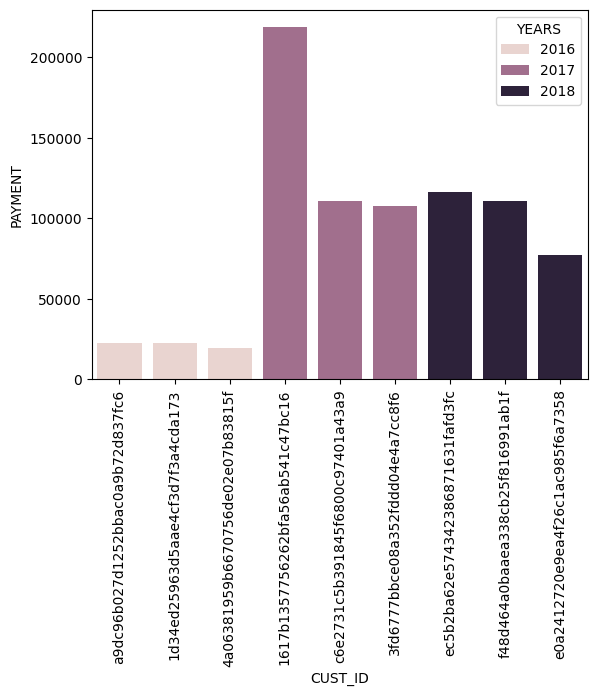

In [11]:
#Identify the top 3 customers who spent the most money in each year.

query="""select YEARS, CUST_ID, PAYMENT, RANKS
from
(select *, dense_rank() over (partition by YEARS order by PAYMENT desc) RANKS
from
(select year(orders.order_purchase_timestamp) YEARS,
#orders.order_id ORDER_ID,
 orders.customer_id CUST_ID, 
 sum(payments.payment_value) PAYMENT
from ecommerce.orders
join ecommerce.payments
on orders.order_id = payments.order_id
group by YEARS, CUST_ID
order by YEARS asc) as A) as d
where RANKS<=3"""
cur.execute(query)
dataset=cur.fetchall()
#dataset
df=pd.DataFrame(data=dataset, columns=["YEARS","CUST_ID","PAYMENT","RANKS"])
df.head(5)
sns.barplot(data=df,x="CUST_ID",y="PAYMENT",hue="YEARS")
plt.xticks(rotation=90)
plt.show()